In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [25]:
from medvqa.utils.files import load_pickle
from medvqa.evaluation.plots import plot_metrics, visualize_image_and_polygons
import numpy as np
import medvqa
import os
from importlib import reload

In [102]:
reload(medvqa.evaluation.plots)

<module 'medvqa.evaluation.plots' from '/home/pamessina/medvqa/medvqa/evaluation/plots.py'>

# 1) Phrase Grounding: DenseNet121 + CXRFE + Sigmoid-based attention

In [9]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-121
create_densenet121_feature_extra

In [11]:
tmp1 = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)/vindrcxr_metrics.pkl')

In [12]:
tmp = tmp1

In [14]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_masks', 'gt_masks', 'ious', 'segmask_iou', 'prc_auc'])

/home/pamessina/venv2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pamessina/venv2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values
posx and posy should be finite values


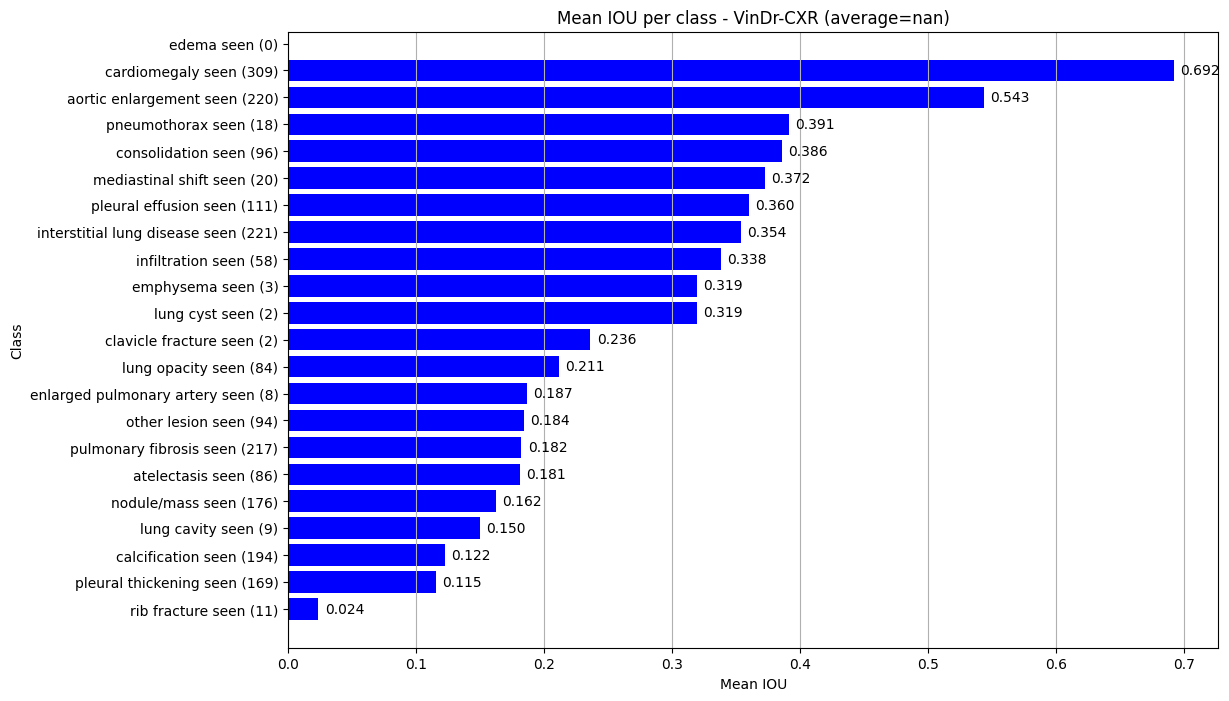

In [15]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [19]:
from medvqa.evaluation.plots import visualize_attention_maps

In [49]:
idxs = np.argsort(tmp['ious'])[::-1]
len(idxs)

2108

In [77]:
# idx = idxs[-200]
idx = idxs[200]
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

0.7070717811584473

/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/889347926c284c6c61234b357153d327.jpg

interstitial lung disease seen


In [23]:
from medvqa.datasets.vinbig import load_test_image_id_2_bboxes,visualize_image_with_bounding_boxes
test_image_id_2_bboxes = load_test_image_id_2_bboxes()

Anomalous bboxes found: 0 of 2697


image_path: /mnt/workspace/vinbig-cxr/dataset-jpg/images/889347926c284c6c61234b357153d327.jpg
0: ILD
[[335.2509977817093, 551.816172253801, 788.6113235322391, 1605.0496119547272], [1269.6155715846303, 485.4707587293333, 1753.3842118672085, 1563.5837285019347]]


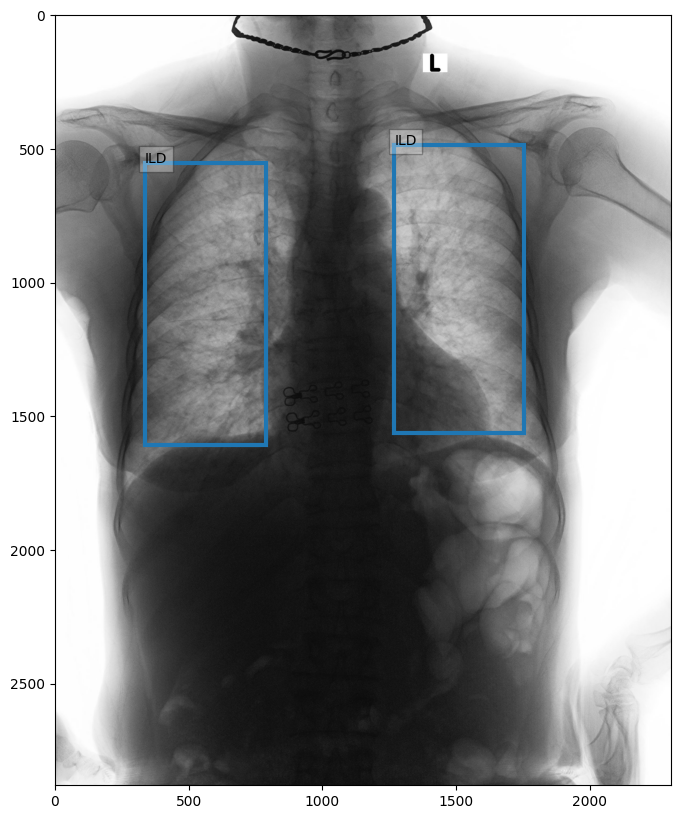

In [78]:
key = os.path.basename(tmp['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, test_image_id_2_bboxes[key], verbose=True)

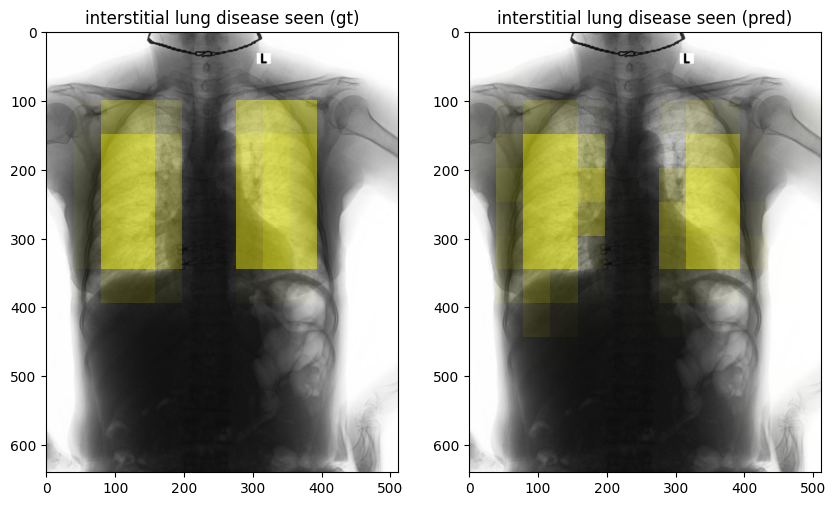

In [79]:
visualize_attention_maps(
    image_path=tmp['image_paths'][idx],
    figsize=(10,10),
    attention_factor=0.5,
    attention_maps=[
        tmp['gt_masks'][idx].reshape(13,13),
        tmp['pred_masks'][idx].reshape(13,13),
    ],
    titles=[
        f"{tmp['phrases'][idx]} (gt)",
        f"{tmp['phrases'][idx]} (pred)",
    ],
)

# 2) Phrase Grounding: DenseNet121 + CXRFE + Transformer Encoder

In [80]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-121
create_densenet121_featu